## Skin Cancer Classification using ResNet50 (HAM10000 Dataset)

This notebook builds and trains a deep learning model for **skin lesion classification** using the **ResNet50 architecture** pretrained on ImageNet.

**Dataset:** [HAM10000](https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000)  
**Classes (7):**
- Melanocytic nevi (nv)
- Melanoma (mel)
- Benign keratosis-like lesions (bkl)
- Basal cell carcinoma (bcc)
- Actinic keratoses (akiec)
- Vascular lesions (vasc)
- Dermatofibroma (df)

## Step 1 — Data Loading and Preprocessing

1. Download HAM10000 dataset using `kagglehub`.
2. Load metadata (`HAM10000_metadata.csv`).
3. Rename columns for clarity and map short diagnosis codes to full names.
4. Fill missing age values with the mean and convert to integer.
5. Encode diagnosis labels (0–6).
6. Check for unmapped values and ensure data consistency.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/skin-cancer-mnist-ham10000


In [ ]:
import os
print("Files in dataset:", os.listdir(path))

Files in dataset: ['hmnist_8_8_RGB.csv', 'hmnist_28_28_RGB.csv', 'HAM10000_images_part_1', 'ham10000_images_part_1', 'hmnist_8_8_L.csv', 'HAM10000_images_part_2', 'ham10000_images_part_2', 'hmnist_28_28_L.csv', 'HAM10000_metadata.csv']


In [ ]:
import pandas as pd
import os

metadata_path = os.path.join(path, "HAM10000_metadata.csv")
metadata = pd.read_csv(metadata_path)



print(metadata.head())
print(metadata.columns)


     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear
Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')


In [ ]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [ ]:
metadata.rename(columns={
    'lesion_id': 'Lesion_ID',
    'image_id': 'Image_ID',
    'dx': 'Diagnosis',
    'dx_type': 'Diagnosis_Type',
    'age': 'Age',
    'sex': 'Sex',
    'localization': 'Localization'
}, inplace=True)


diagnosis_map = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}

metadata['Diagnosis'] = metadata['Diagnosis'].map(diagnosis_map)


print(metadata.head())


     Lesion_ID      Image_ID                            Diagnosis  \
0  HAM_0000118  ISIC_0027419  Benign keratosis-like lesions (bkl)   
1  HAM_0000118  ISIC_0025030  Benign keratosis-like lesions (bkl)   
2  HAM_0002730  ISIC_0026769  Benign keratosis-like lesions (bkl)   
3  HAM_0002730  ISIC_0025661  Benign keratosis-like lesions (bkl)   
4  HAM_0001466  ISIC_0031633  Benign keratosis-like lesions (bkl)   

  Diagnosis_Type   Age   Sex Localization  
0          histo  80.0  male        scalp  
1          histo  80.0  male        scalp  
2          histo  80.0  male        scalp  
3          histo  80.0  male        scalp  
4          histo  75.0  male          ear  


In [ ]:
metadata.isnull().sum()

,0
Lesion_ID,0
Image_ID,0
Diagnosis,0
Diagnosis_Type,0
Age,57
Sex,0
Localization,0


In [ ]:
# Handling null values
metadata['Age'].fillna(value=int(metadata['Age'].mean()), inplace=True)
# Converting dtype of age to int32
metadata['Age'] = metadata['Age'].astype('int32')
# Categorically encoding label of the images

label_mapping = {
    'Melanocytic nevi (nv)': 0,
    'Melanoma (mel)': 1,
    'Benign keratosis-like lesions (bkl)': 2,
    'Basal cell carcinoma (bcc)': 3,
    'Actinic keratoses (akiec)': 4,
    'Vascular lesions (vasc)': 5,
    'Dermatofibroma (df)': 6
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

# Clean the 'Diagnosis' column by stripping whitespace
metadata['Diagnosis'] = metadata['Diagnosis'].str.strip()

metadata['label'] = metadata['Diagnosis'].map(label_mapping)

# Check for any unmapped diagnosis values
unmapped_diagnoses = metadata[metadata['label'].isna()]['Diagnosis'].unique()
if len(unmapped_diagnoses) > 0:
    print("\nWarning: The following diagnosis values were not mapped:", unmapped_diagnoses)

print("\nUnique values in 'Diagnosis' column after cleaning:", metadata['Diagnosis'].unique())
metadata.sample(5)


Unique values in 'Diagnosis' column after cleaning: ['Benign keratosis-like lesions (bkl)' 'Melanocytic nevi (nv)'
 'Dermatofibroma (df)' 'Melanoma (mel)' 'Vascular lesions (vasc)'
 'Basal cell carcinoma (bcc)' 'Actinic keratoses (akiec)']


/tmp/ipython-input-1824236454.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  metadata['Age'].fillna(value=int(metadata['Age'].mean()), inplace=True)


,Lesion_ID,Image_ID,Diagnosis,Diagnosis_Type,Age,Sex,Localization,label
8813,HAM_0005745,ISIC_0030873,Melanocytic nevi (nv),histo,45,male,abdomen,0
589,HAM_0006211,ISIC_0025519,Benign keratosis-like lesions (bkl),histo,50,male,neck,2
8513,HAM_0000129,ISIC_0027486,Melanocytic nevi (nv),histo,40,female,back,0
264,HAM_0004406,ISIC_0034125,Benign keratosis-like lesions (bkl),histo,80,male,back,2
9206,HAM_0005250,ISIC_0029792,Melanocytic nevi (nv),histo,40,female,foot,0


In [ ]:
# Handling null values
metadata['Age'].fillna(value=int(metadata['Age'].mean()), inplace=True)
# Converting dtype of age to int32
metadata['Age'] = metadata['Age'].astype('int32')
# Categorically encoding label of the images
metadata.sample(5)

/tmp/ipython-input-3540768875.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  metadata['Age'].fillna(value=int(metadata['Age'].mean()), inplace=True)


,Lesion_ID,Image_ID,Diagnosis,Diagnosis_Type,Age,Sex,Localization,label
8414,HAM_0005614,ISIC_0030397,Melanocytic nevi (nv),histo,35,female,trunk,0
2140,HAM_0000136,ISIC_0028065,Melanoma (mel),histo,60,male,back,1
1018,HAM_0003287,ISIC_0026846,Benign keratosis-like lesions (bkl),consensus,80,male,upper extremity,2
2921,HAM_0001237,ISIC_0029680,Basal cell carcinoma (bcc),histo,70,male,lower extremity,3
9076,HAM_0003125,ISIC_0025477,Melanocytic nevi (nv),histo,55,male,chest,0


In [ ]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Lesion_ID       10015 non-null  object
 1   Image_ID        10015 non-null  object
 2   Diagnosis       10015 non-null  object
 3   Diagnosis_Type  10015 non-null  object
 4   Age             10015 non-null  int32 
 5   Sex             10015 non-null  object
 6   Localization    10015 non-null  object
 7   label           10015 non-null  int64 
dtypes: int32(1), int64(1), object(6)
memory usage: 586.9+ KB


     Lesion_ID      Image_ID                            Diagnosis  \
0  HAM_0000118  ISIC_0027419  Benign keratosis-like lesions (bkl)   
1  HAM_0000118  ISIC_0025030  Benign keratosis-like lesions (bkl)   
2  HAM_0002730  ISIC_0026769  Benign keratosis-like lesions (bkl)   
3  HAM_0002730  ISIC_0025661  Benign keratosis-like lesions (bkl)   
4  HAM_0001466  ISIC_0031633  Benign keratosis-like lesions (bkl)   

  Diagnosis_Type  Age   Sex Localization  label  
0          histo   80  male        scalp      2  
1          histo   80  male        scalp      2  
2          histo   80  male        scalp      2  
3          histo   80  male        scalp      2  
4          histo   75  male          ear      2  

Diagnosis Counts:
Diagnosis
Melanocytic nevi (nv)                  6705
Melanoma (mel)                         1113
Benign keratosis-like lesions (bkl)    1099
Basal cell carcinoma (bcc)              514
Actinic keratoses (akiec)               327
Vascular lesions (vasc)             

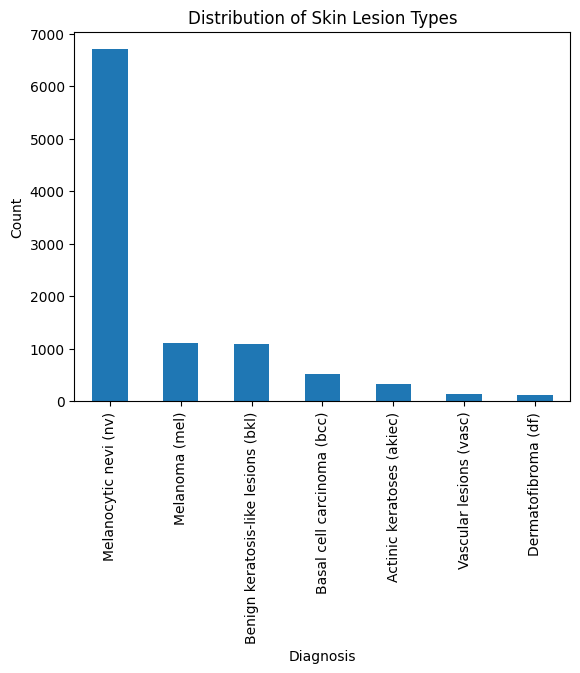

In [ ]:
print(metadata.head())

print("\nDiagnosis Counts:")
print(metadata['Diagnosis'].value_counts())

import matplotlib.pyplot as plt
metadata['Diagnosis'].value_counts().plot(kind='bar')
plt.title("Distribution of Skin Lesion Types")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.show()


## Step 2 — Handling Class Imbalance

- The HAM10000 dataset is naturally imbalanced.
- Rare classes are **oversampled** by duplicating rows to balance the training set.
- Class distributions are visualized before and after balancing.

In [ ]:
df_label1 = metadata[metadata['label'] == 1]
df_label2 = metadata[metadata['label'] == 2]
df_label3 = metadata[metadata['label'] == 3]
df_label4 = metadata[metadata['label'] == 4]
df_label5 = metadata[metadata['label'] == 5]
df_label6 = metadata[metadata['label'] == 6]

In [ ]:
df_label1_ovs = pd.concat([df_label1] * 5, ignore_index=True)
df_label2_ovs = pd.concat([df_label2] * 5, ignore_index=True)
df_label3_ovs = pd.concat([df_label3] * 12, ignore_index=True)
df_label4_ovs = pd.concat([df_label4] * 19, ignore_index=True)
df_label5_ovs = pd.concat([df_label5] * 46, ignore_index=True)
df_label6_ovs = pd.concat([df_label6] * 57, ignore_index=True)

In [ ]:
final_metadata = pd.concat([metadata,
                        df_label1_ovs,
                        df_label2_ovs,
                        df_label3_ovs,
                        df_label4_ovs,
                        df_label5_ovs,
                        df_label6_ovs], ignore_index=True)

     Lesion_ID      Image_ID                            Diagnosis  \
0  HAM_0000118  ISIC_0027419  Benign keratosis-like lesions (bkl)   
1  HAM_0000118  ISIC_0025030  Benign keratosis-like lesions (bkl)   
2  HAM_0002730  ISIC_0026769  Benign keratosis-like lesions (bkl)   
3  HAM_0002730  ISIC_0025661  Benign keratosis-like lesions (bkl)   
4  HAM_0001466  ISIC_0031633  Benign keratosis-like lesions (bkl)   

  Diagnosis_Type  Age   Sex Localization  label  
0          histo   80  male        scalp      2  
1          histo   80  male        scalp      2  
2          histo   80  male        scalp      2  
3          histo   80  male        scalp      2  
4          histo   75  male          ear      2  

Diagnosis Counts:
Diagnosis
Melanocytic nevi (nv)                  6705
Basal cell carcinoma (bcc)             6682
Melanoma (mel)                         6678
Vascular lesions (vasc)                6674
Dermatofibroma (df)                    6670
Benign keratosis-like lesions (bkl) 

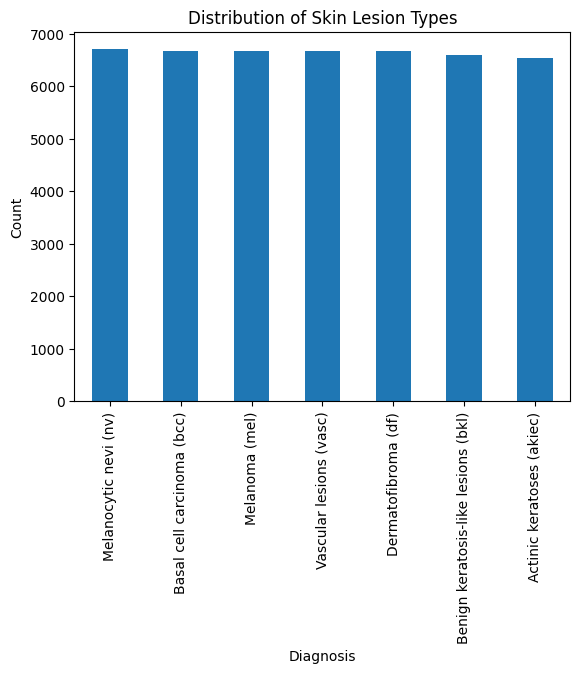

In [ ]:
print(final_metadata.head())

print("\nDiagnosis Counts:")
print(final_metadata['Diagnosis'].value_counts())

import matplotlib.pyplot as plt
final_metadata['Diagnosis'].value_counts().plot(kind='bar')
plt.title("Distribution of Skin Lesion Types")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.show()

## Step 3 — Preparing Image Paths and Dataset Splits

- A helper function locates images in the two dataset folders.
- Add an `image_path` column to the metadata.
- Split data into:
  - **Training (64%)**
  - **Validation (16%)**
  - **Testing (20%)**
- Stratified sampling ensures all sets keep the same label distribution.


In [ ]:
import os

image_dir1 = os.path.join(path, "HAM10000_images_part_1")
image_dir2 = os.path.join(path, "HAM10000_images_part_2")

def get_image_path(image_id):
    if os.path.exists(os.path.join(image_dir1, image_id + ".jpg")):
        return os.path.join(image_dir1, image_id + ".jpg")
    else:
        return os.path.join(image_dir2, image_id + ".jpg")

final_metadata['image_path'] = final_metadata['Image_ID'].apply(get_image_path)


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(final_metadata, test_size=0.2, stratify=final_metadata['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)


## Step 4 — Image Data Generators

- Use `ImageDataGenerator` to:
  - Normalize all images to [0,1] range
  - Apply data augmentation (rotation, shift, horizontal flip) on training images
- Validation and test sets are only rescaled (no augmentation).
- Input size is set to **224×224 pixels** for ResNet50.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224  # ResNet50 input size

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='Diagnosis',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=32
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='Diagnosis',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=32
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='Diagnosis',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 29787 validated image filenames belonging to 7 classes.
Found 7447 validated image filenames belonging to 7 classes.
Found 9309 validated image filenames belonging to 7 classes.


## Step 5 — Building the ResNet50 Model

- Load **ResNet50 pretrained on ImageNet** (`include_top=False`).
- Unfreeze the **last 30 layers** for fine-tuning.
- Add custom layers:
  - `Flatten → Dense(256, relu) → Dropout(0.5) → Dense(7, softmax)`
- Compile model with:
  - Optimizer: `Adam(lr=1e-4)`
  - Loss: `categorical_crossentropy`
  - Metric: `accuracy`


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import *

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[-30:]:
    layer.trainable = True

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])


In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,279,879 (187.99 MB)

 Trainable params: 49,226,759 (187.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

## Step 6 — Training the Model

- Use callbacks:
  - `EarlyStopping` (monitor validation accuracy, patience=5)
  - `ModelCheckpoint` (save best model automatically)
- Train for **10 epochs** on the augmented training data.
- Save the final model as `skin_cancer_resnet50_finetuned.h5`.

In [ ]:
# 5. Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_skin_cancer_model.h5", monitor='val_accuracy', save_best_only=True)
]

In [ ]:
history = model.fit(train_generator,validation_data=val_generator,epochs=10,callbacks=callbacks)

Epoch 1/10
931/931 ━━━━━━━━━━━━━━━━━━━━ 0s 725ms/step - accuracy: 0.6338 - loss: 1.2099

931/931 ━━━━━━━━━━━━━━━━━━━━ 826s 811ms/step - accuracy: 0.6339 - loss: 1.2094 - val_accuracy: 0.3459 - val_loss: 3.0963
Epoch 2/10
931/931 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.8652 - loss: 0.3872

931/931 ━━━━━━━━━━━━━━━━━━━━ 730s 784ms/step - accuracy: 0.8652 - loss: 0.3872 - val_accuracy: 0.6924 - val_loss: 1.6547
Epoch 3/10
931/931 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.8851 - loss: 0.3596

931/931 ━━━━━━━━━━━━━━━━━━━━ 730s 784ms/step - accuracy: 0.8851 - loss: 0.3595 - val_accuracy: 0.7786 - val_loss: 0.7921
Epoch 4/10
931/931 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.9270 - loss: 0.2163

931/931 ━━━━━━━━━━━━━━━━━━━━ 734s 788ms/step - accuracy: 0.9270 - loss: 0.2163 - val_accuracy: 0.8324 - val_loss: 0.7796
Epoch 5/10
931/931 ━━━━━━━━━━━━━━━━━━━━ 704s 756ms/step - accuracy: 0.9454 - loss: 0.1592 - val_accuracy: 0.7547 - val_loss: 0.8510
Epoch 6/10
931/931 ━━━━━━━━━━━━━━━━━━━━ 701s 753ms/step - accuracy: 0.9365 - loss: 0.1915 - val_accuracy: 0.6028 - val_loss: 3.6535
Epoch 7/10
931/931 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.9460 - loss: 0.1565

931/931 ━━━━━━━━━━━━━━━━━━━━ 728s 782ms/step - accuracy: 0.9460 - loss: 0.1565 - val_accuracy: 0.8975 - val_loss: 0.3093
Epoch 8/10
931/931 ━━━━━━━━━━━━━━━━━━━━ 700s 751ms/step - accuracy: 0.9590 - loss: 0.1220 - val_accuracy: 0.8888 - val_loss: 0.5250
Epoch 9/10
931/931 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.9624 - loss: 0.1202

931/931 ━━━━━━━━━━━━━━━━━━━━ 744s 799ms/step - accuracy: 0.9624 - loss: 0.1203 - val_accuracy: 0.9157 - val_loss: 0.2899
Epoch 10/10
931/931 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9646 - loss: 0.1137

931/931 ━━━━━━━━━━━━━━━━━━━━ 719s 772ms/step - accuracy: 0.9646 - loss: 0.1137 - val_accuracy: 0.9589 - val_loss: 0.1205


In [ ]:
model.save("skin_cancer_resnet50_finetuned.h5")
print("Model saved successfully!")

Model saved successfully!


## Step 7 — Model Evaluation

- Predict on the test dataset.
- Generate:
  - **Classification report** (precision, recall, F1-score per class)
  - **Confusion matrix** using Seaborn heatmap
  - **Training vs. validation accuracy and loss** plots
- Print **final test accuracy and loss**.


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred_classes, target_names=class_labels))


291/291 ━━━━━━━━━━━━━━━━━━━━ 92s 300ms/step
                                     precision    recall  f1-score   support

          Actinic keratoses (akiec)       0.99      0.99      0.99      1308
         Basal cell carcinoma (bcc)       0.99      0.99      0.99      1336
Benign keratosis-like lesions (bkl)       0.94      0.94      0.94      1319
                Dermatofibroma (df)       0.99      1.00      1.00      1334
              Melanocytic nevi (nv)       0.84      0.93      0.88      1341
                     Melanoma (mel)       0.96      0.85      0.90      1336
            Vascular lesions (vasc)       1.00      1.00      1.00      1335

                           accuracy                           0.96      9309
                          macro avg       0.96      0.96      0.96      9309
                       weighted avg       0.96      0.96      0.96      9309



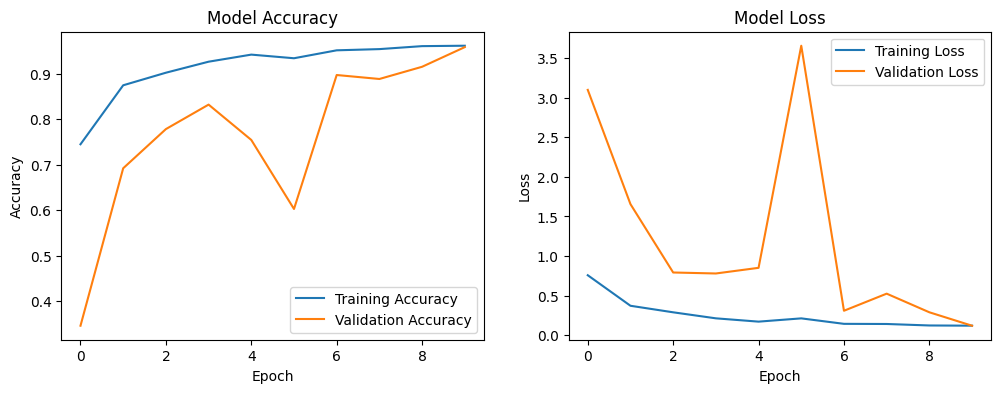


Test Accuracy: 0.9576
Test Loss: 0.1222


In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate the model on the test set to get test accuracy and loss
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

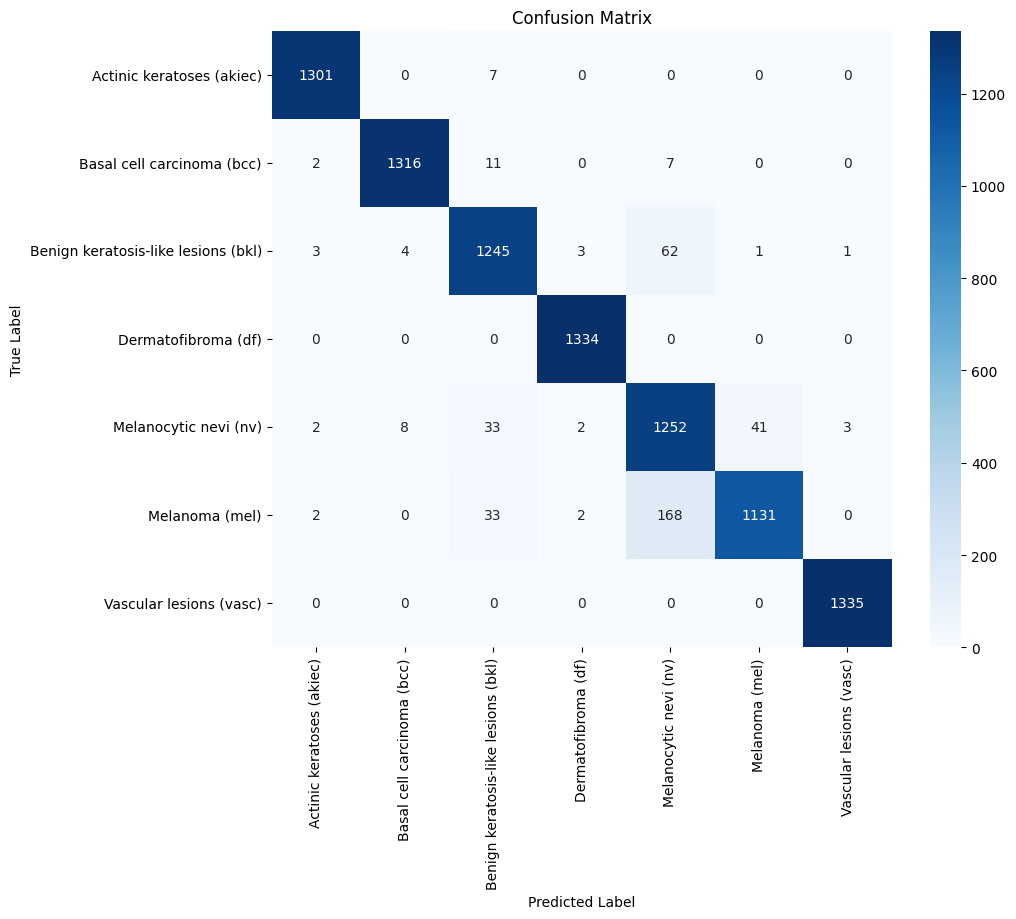

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Outputs and Next Steps

**Outputs:**
- Trained model file: `skin_cancer_resnet50_finetuned.h5`
- Best model checkpoint: `best_skin_cancer_model.h5`
- Performance metrics and plots

**Possible Improvements:**
- Use class weights instead of oversampling
- Replace `Flatten()` with `GlobalAveragePooling2D()` to reduce parameters
- Add `ReduceLROnPlateau` to dynamically lower learning rate
- Compute per-class ROC-AUC (more informative for medical tasks)
- Train longer with smaller learning rate for better convergence